# Setup

In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import glob
import unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_size = 900
val_size = 100
batch_size = 4

# Dataloader

C:\Users\aidan\AppData\Local\Temp\ipykernel_8788\4196854938.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load('../../data/synth_data_new/0.pt')


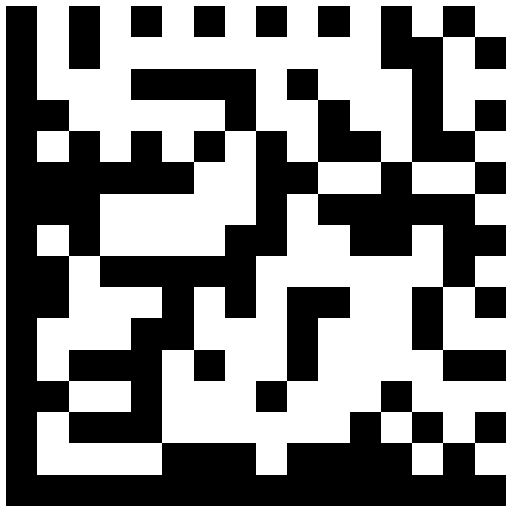

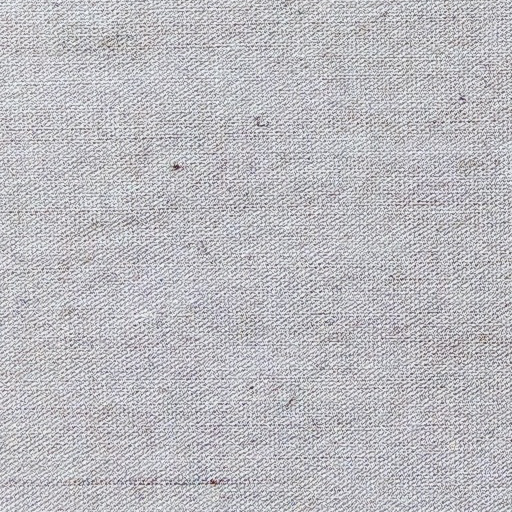

In [2]:
# helper for loading images
def tensors2PIL(tensor):
    # split into DMC and texture images
    dmc_img = tensor[0].numpy()
    texture_img = tensor[1:].numpy()

    # multiply by 255 to convert to 0-255 range
    dmc_img = dmc_img * 255
    texture_img = texture_img * 255

    # ensure no values are above 255
    dmc_img[dmc_img > 255] = 255
    texture_img[texture_img > 255] = 255

    # convert to uint8
    dmc_img = dmc_img.astype(np.uint8)
    texture_img = texture_img.astype(np.uint8)

    # reshape dmc_img to 2D
    dmc_img = dmc_img.reshape(512, 512)

    # reshape texture_img to 3D with 3 channels
    texture_img = texture_img.reshape(3, 512, 512).transpose(1, 2, 0)

    # convert to PIL images
    dmc_img = Image.fromarray(dmc_img).convert('L')
    texture_img = Image.fromarray(texture_img).convert('RGB')

    return dmc_img, texture_img

tensor = torch.load('../../data/synth_data_new/0.pt')

dmc_img, texture_img = tensors2PIL(tensor)

display(dmc_img)
display(texture_img)

In [3]:
def shape_transform(tensor):
    '''Applies random shape transformations to image'''

    # unsqueeze tensor to add batch dimension
    tensor = tensor.unsqueeze(0)

    # Calculate padding to compensate for random affine
    width, height = tensor.shape[1], tensor.shape[2]
    diagonal = math.sqrt(width**2 + height**2)
    padding = math.ceil((diagonal - width) / 2)

    transforms = v2.Compose([
        v2.Pad(padding, fill=255, padding_mode='constant'),
        v2.RandomRotation(random.randrange(0, 360), fill=255, interpolation=Image.BILINEAR, expand=True),
        v2.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=Image.BILINEAR, fill=255),
        v2.RandomAffine(degrees=0,
                        # random "squish" on x and y axis
                        shear=(-random.randrange(10,20), random.randrange(10,20), -random.randrange(10,20), random.randrange(10,20)),
                        fill=255,
                        interpolation=Image.BILINEAR,
                        ),
    ])

    tensor = transforms(tensor)

    # crop image down to black pixels
    coords = np.argwhere(np.array(tensor[0]) < 1)
    top_left = coords.min(axis=0)
    bottom_right = coords.max(axis=0) + 1 # +1 to include last pixel
    tensor = v2.functional.crop(tensor, top=top_left[0], left=top_left[1], height=bottom_right[0]-top_left[0], width=bottom_right[1]-top_left[1])

    # resize image to original size
    tensor = v2.functional.resize(tensor, (width, height), interpolation=Image.BILINEAR)

    # binarize image
    tensor = torch.where(tensor > 0.5, torch.tensor(1.0), torch.tensor(0.0))

    # remove batch dimension
    tensor = tensor.squeeze(0)

    return tensor

C:\Users\aidan\AppData\Local\Temp\ipykernel_8788\3160978877.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load('../../data/synth_data_new/0.pt')


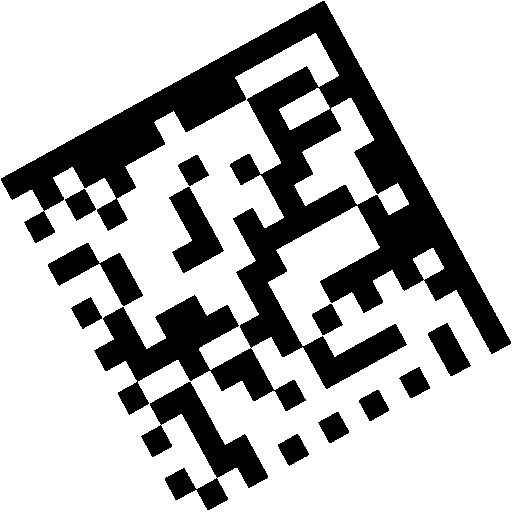

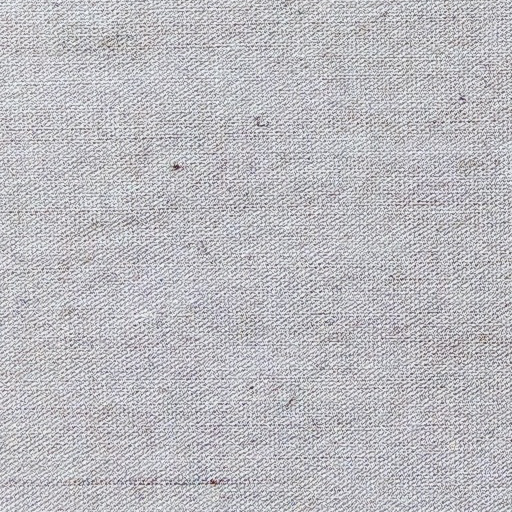

In [4]:
# testing shape_transform
tensor = torch.load('../../data/synth_data_new/0.pt')
tensor[0] = shape_transform(tensor[0])
dmc_img, texture_img = tensors2PIL(tensor)
display(dmc_img)
display(texture_img)

In [5]:
def combine_images(tensor):
    '''Combines DMC and texture tensors into one tensor'''
    dmc = tensor[0].unsqueeze(0)
    texture = tensor[1:].unsqueeze(0)

    # increment black pixel intensity of DMC randomly
    increment = random.uniform(0.1, 0.5)
    dmc = torch.where(dmc < 0.5, dmc + increment, dmc)

    # multiply DMC onto each texture channel
    texture = torch.mul(texture, dmc)

    # combine DMC and texture tensors via multiplication
    # texture = torch.mul(texture, dmc)

    # combined = torch.cat((dmc, texture), dim=0)

    return texture

C:\Users\aidan\AppData\Local\Temp\ipykernel_8788\3191254161.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load('../../data/synth_data_new/0.pt')


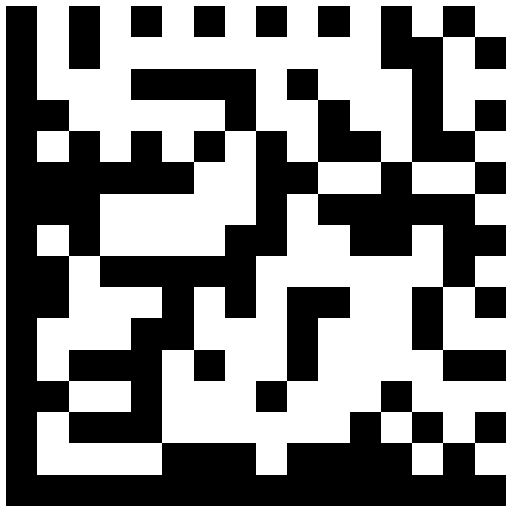

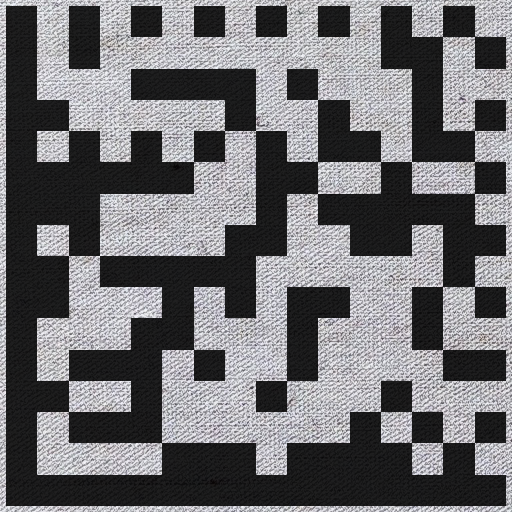

In [6]:
# testing combine_images
tensor = torch.load('../../data/synth_data_new/0.pt')
tensor[1:] = combine_images(tensor)
dmc_img, texture_img = tensors2PIL(tensor)
display(dmc_img)
display(texture_img)

In [7]:
def color_transform(tensor):
    '''Applies random color transformations to image'''

    # unsqueeze tensor to add batch dimension
    tensor = tensor.unsqueeze(0)

    # random kernel size for gaussian blur
    kernel_size = random.choice([7, 9, 11])
    sharpness = random.uniform(0.5, 1.5)

    transforms = v2.Compose([
        # v2.ColorJitter(brightness = (0.5, 1.5),
        #                contrast   = (0.5, 1.5),
        #                saturation = (0.5, 1.5),
        #                hue        = (-0.5, 0.5),
        #                ),
        # v2.RandomChannelPermutation(),
        v2.RandomPhotometricDistort(brightness = (0.5, 1.5),
                                    contrast   = (0.5, 1.5),
                                    saturation = (0.5, 1.5),
                                    hue        = (-0.5, 0.5),
                                    ),
        v2.GaussianBlur(kernel_size=kernel_size, sigma=(0.1, 100.0)), # chance to blur a lot or a little - mostly an ok amount
        # v2.GaussianNoise(), # not implemented for PIL images
        # v2.RandomInvert(0.2), # lower chance of inversion # apply to code not background
        # v2.RandomPosterize(8),
        # v2.RandomSolarize(0.5, 0.5),
        v2.RandomAdjustSharpness(sharpness, 0.5),
        # v2.RandomAutocontrast(),
        # v2.RandomEqualize(0.2), # lower chance of equalization
    ])

    tensor = transforms(tensor)

    # remove batch dimension
    tensor = tensor.squeeze(0)

    return tensor

C:\Users\aidan\AppData\Local\Temp\ipykernel_8788\2479305815.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load('../../data/synth_data_new/0.pt')


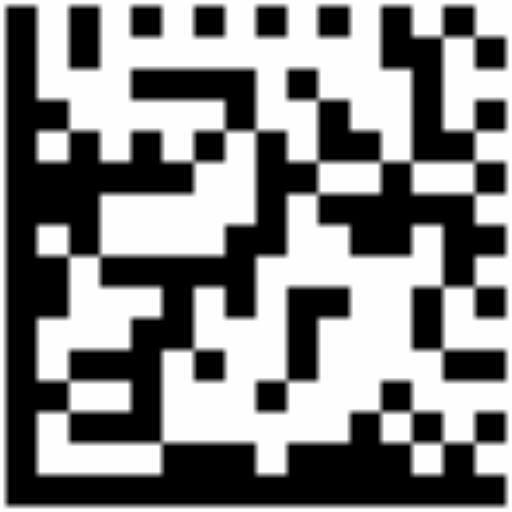

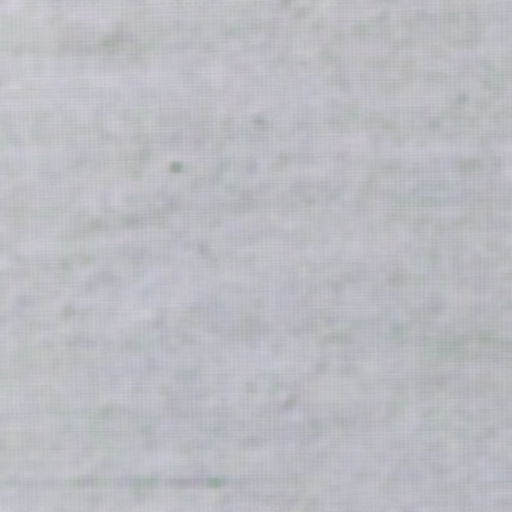

In [8]:
# testing color_transform
tensor = torch.load('../../data/synth_data_new/0.pt')
tensor[0] = color_transform(tensor[0])
tensor[1:] = color_transform(tensor[1:])
dmc_img, texture_img = tensors2PIL(tensor)
display(dmc_img)
display(texture_img)

C:\Users\aidan\AppData\Local\Temp\ipykernel_8788\14467220.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load('../../data/synth_data_new/5.pt')


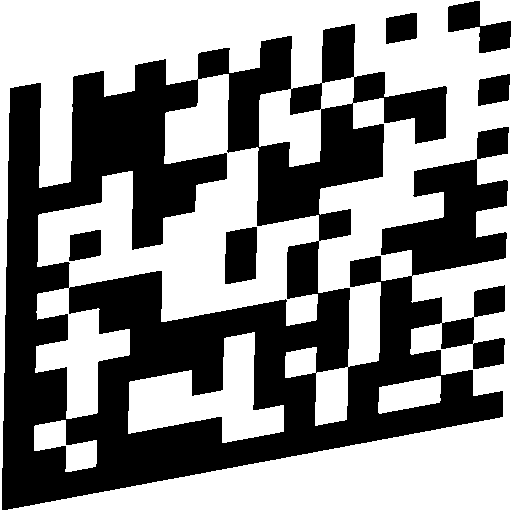

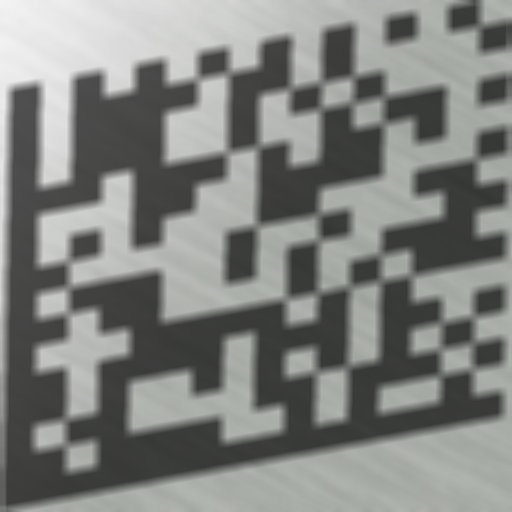

In [9]:
# testing all transforms
tensor = torch.load('../../data/synth_data_new/5.pt')
tensor[0] = shape_transform(tensor[0])
tensor[1:] = combine_images(tensor)
tensor[1:] = color_transform(tensor[1:])
dmc_img, texture_img = tensors2PIL(tensor)
display(dmc_img)
display(texture_img)

In [10]:
class DMCDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image and mask
        tensor = torch.load(self.image_paths[idx])
        tensor[0] = shape_transform(tensor[0])
        tensor[1:] = combine_images(tensor)
        tensor[1:] = color_transform(tensor[1:])

        image = tensor[1:]
        mask = tensor[0].unsqueeze(0)

        return image, mask

In [11]:
# train and validation image paths
train_tensor_paths = glob.glob('../../data/synth_data_new/*.pt')[:train_size]
val_tensor_paths = glob.glob('../../data/synth_data_new/*.pt')[-val_size:]

# Create dataset and dataloader
train_dataset = DMCDataset(train_tensor_paths)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = DMCDataset(val_tensor_paths)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

C:\Users\aidan\AppData\Local\Temp\ipykernel_8788\3198414592.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(self.image_paths[idx])


torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


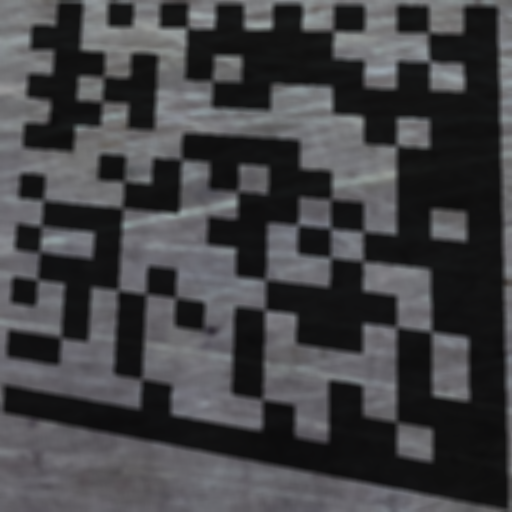

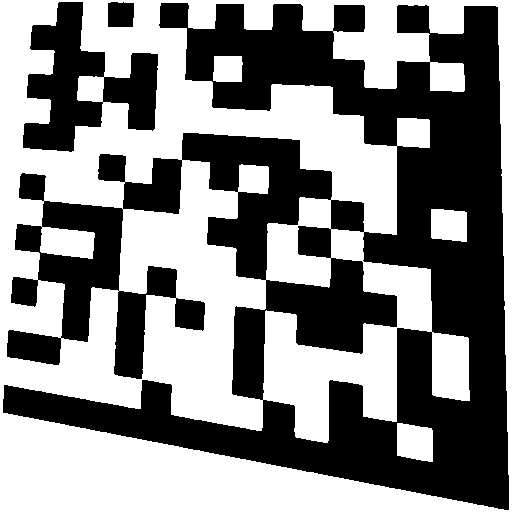

In [12]:
# train dataset example
for i, (image, mask) in enumerate(train_dataset):
    print(image.shape, mask.shape)
    break

# train Dataloader example
for i, (image, mask) in enumerate(train_dataloader):
    print(image.shape, mask.shape)
    image = v2.ToPILImage()(image[0].squeeze(0))
    display(image)

    mask = v2.ToPILImage()(mask[0].squeeze(0))
    display(mask)
    break

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])


C:\Users\aidan\AppData\Local\Temp\ipykernel_8788\3198414592.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(self.image_paths[idx])


torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


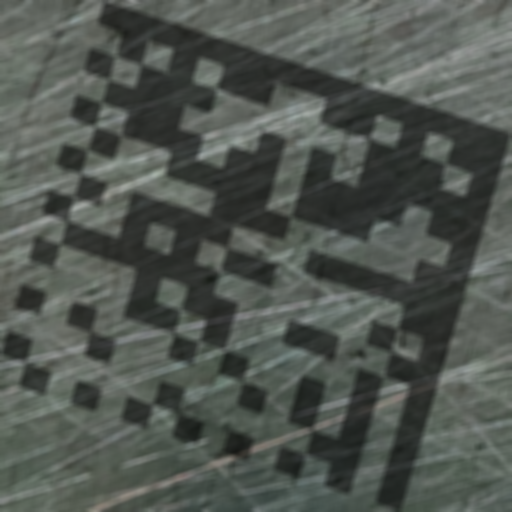

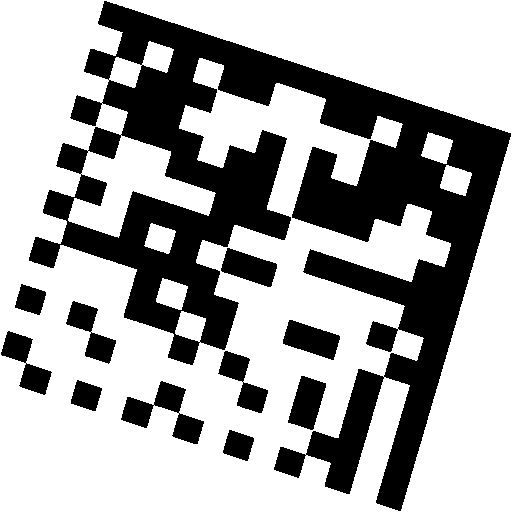

In [13]:
# validation dataset example
for i, (image, mask) in enumerate(val_dataset):
    print(image.shape, mask.shape)
    break

# validation Dataloader example
for i, (image, mask) in enumerate(val_dataloader):
    print(image.shape, mask.shape)
    image = v2.ToPILImage()(image[0].squeeze(0))
    display(image)

    mask = v2.ToPILImage()(mask[0].squeeze(0))
    display(mask)
    break

# Training Loop

In [14]:
# Loss function - balances between two methods
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, output, target):
        smooth = 1.0  # To avoid division by zero
        output = output.contiguous().view(-1)
        target = target.contiguous().view(-1)
        intersection = (output * target).sum()
        dice = (2. * intersection + smooth) / (output.sum() + target.sum() + smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=1, dice_weight=1):
        super(BCEDiceLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, output, target):
        bce_loss = self.bce(output, target)
        dice_loss = self.dice(output, target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

In [15]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [16]:
# setup
model = unet.binarizer(in_channels=3, out_channels=1).to(device)

# params
num_epochs = 999999

# Optimizer - try with others
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# criterion = nn.BCELoss()
# criterion = DiceLoss()
criterion = BCEDiceLoss(bce_weight=1.0, dice_weight=1.0)
early_stopper = EarlyStopper(patience=1, min_delta=0.001)

In [17]:
# Actual training loop
prev_loss = 999999
for epoch in range(num_epochs):
    model.train()

    # train loop
    train_loss = 0.0
    count = 0
    for images, masks in train_dataloader: # consider renaming masks to targets
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images) # Add batch dimension to input

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        count += batch_size
        print(f'Training - {count}/{train_size}', end='\r')

    # validation loop
    model.eval()
    val_loss = 0.0
    count = 0
    with torch.no_grad():
        for images, masks in val_dataloader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            count += batch_size
            print(f'Validating - {count}/{val_size}', end='\r')

    # early stopping if validation loss increases
    if early_stopper.early_stop(val_loss):
        print(f'Early stopping at epoch {epoch}')
        break

    print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss / len(train_dataloader):.4f}, Val Loss: {val_loss / len(val_dataloader):.4f}')

    # Save the model
    torch.save(model.state_dict(), '../../torch/binarizer_102.pt')

C:\Users\aidan\AppData\Local\Temp\ipykernel_8788\3198414592.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(self.image_paths[idx])


Epoch [0/999999], Train Loss: 0.7028, Val Loss: 0.4924
Epoch [1/999999], Train Loss: 0.2815, Val Loss: 0.1963
Epoch [2/999999], Train Loss: 0.1871, Val Loss: 0.1587
Epoch [3/999999], Train Loss: 0.1730, Val Loss: 0.1363
Epoch [4/999999], Train Loss: 0.1483, Val Loss: 0.1275
Epoch [5/999999], Train Loss: 0.1393, Val Loss: 0.1137
Epoch [6/999999], Train Loss: 0.1178, Val Loss: 0.0955
Early stopping at epoch 7


- 100 = BCE
- 101 = Dice
- 102 = BCEDice

# Evaluation

C:\Users\aidan\AppData\Local\Temp\ipykernel_8788\3198414592.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(self.image_paths[idx])


Output range: min=1.2932787285535596e-06, max=1.0
Output range after binarization: min=0.0, max=1.0
Mean IoU: 0.2402
Mean Dice Coefficient: 0.2449
Mean Pixel Accuracy: 0.2434


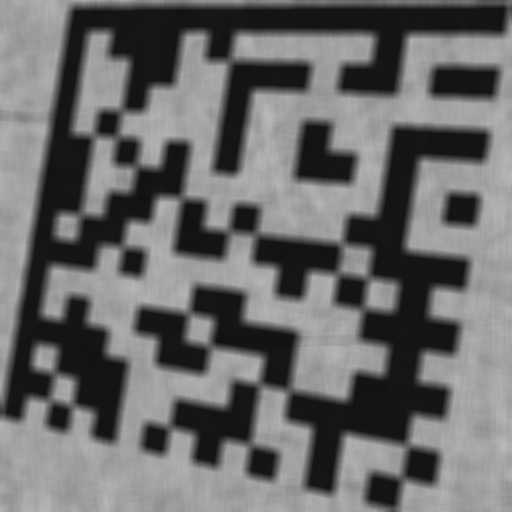

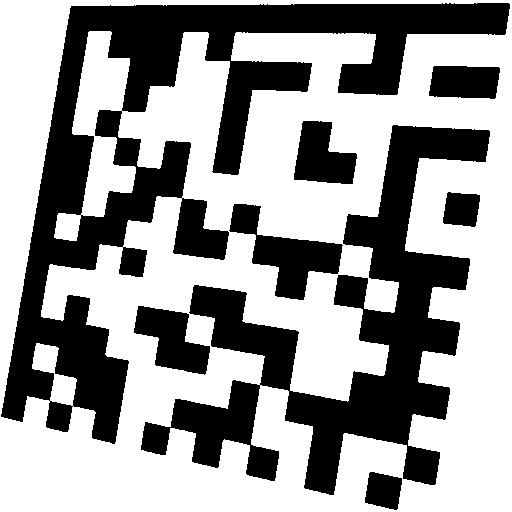

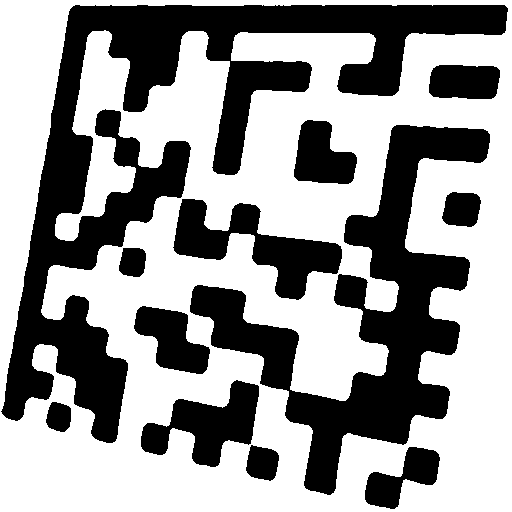

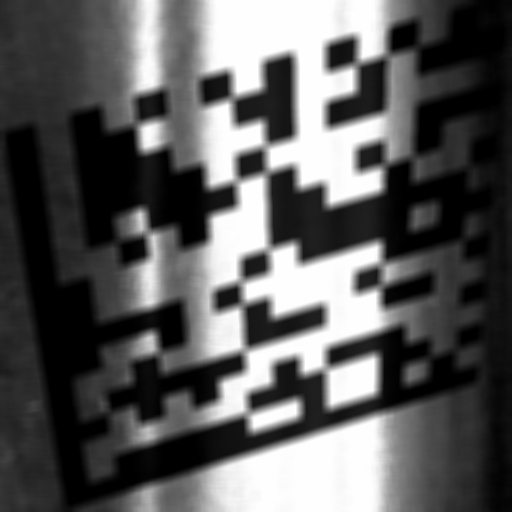

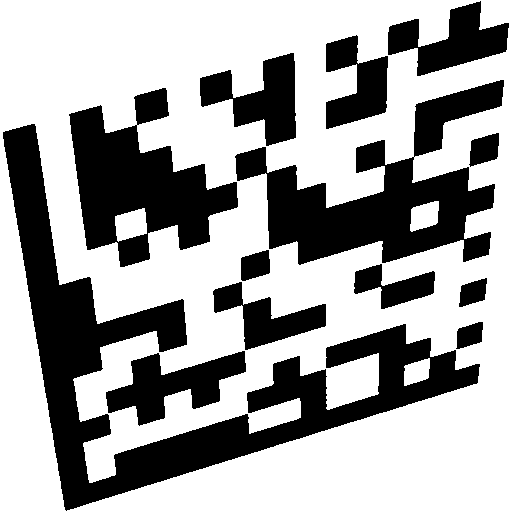

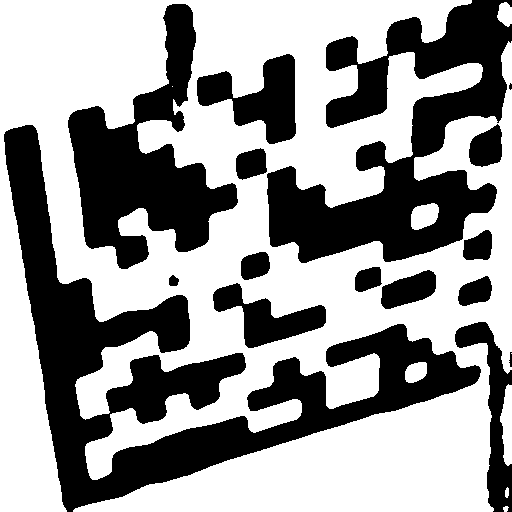

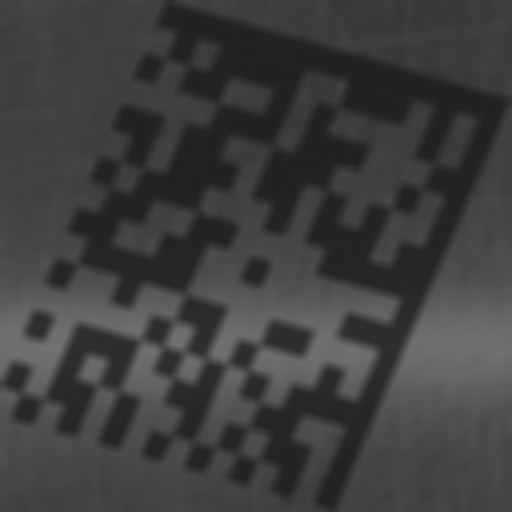

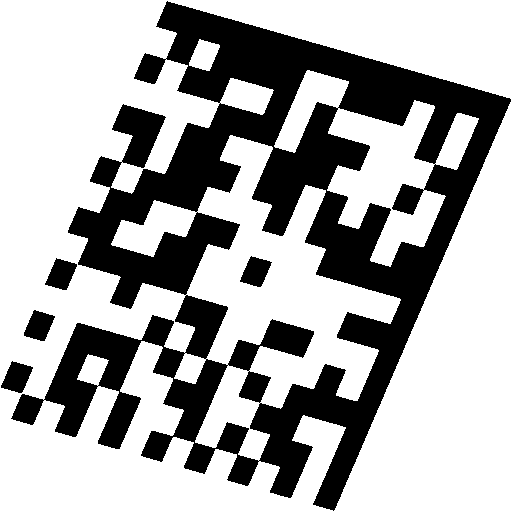

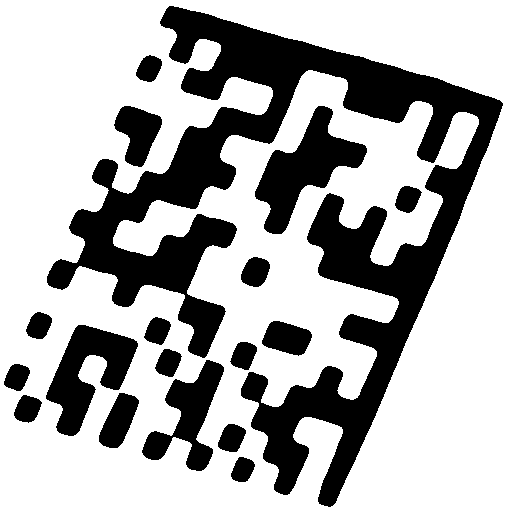

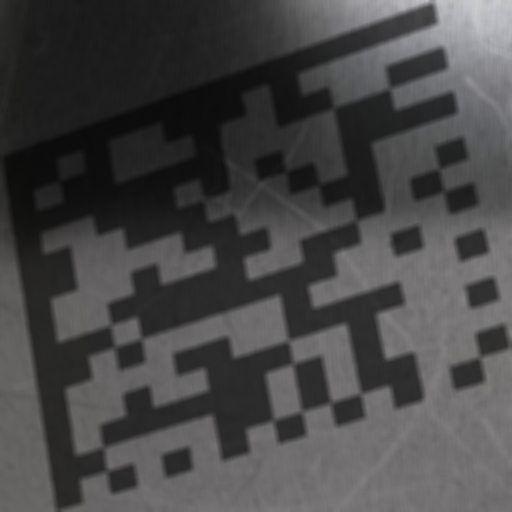

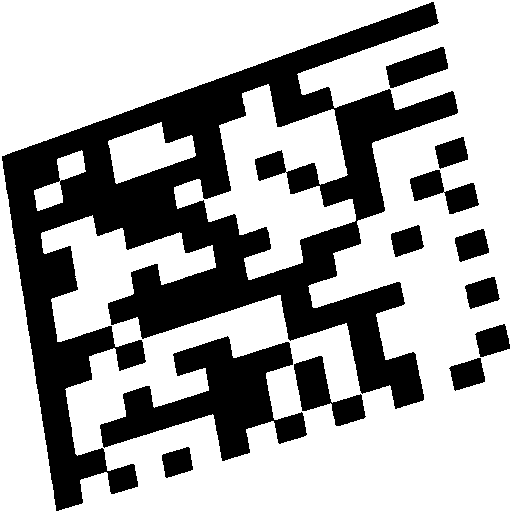

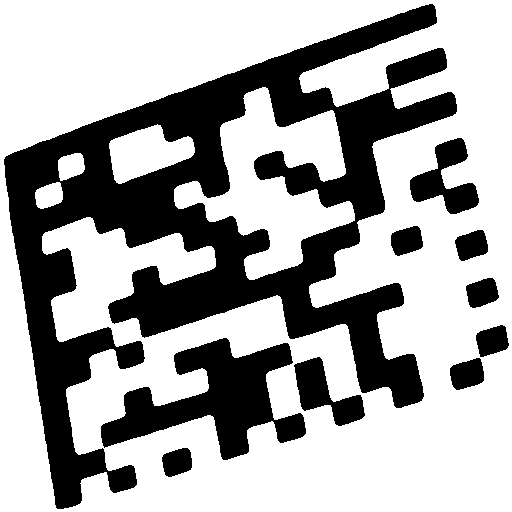

(0.2402419465780258, 0.24494786262512208, 0.24343330383300782)

In [18]:
def evaluate_model(model, val_loader, threshold=0.5):
    model.eval()  # Set model to evaluation mode

    iou_total = 0
    dice_total = 0
    accuracy_total = 0
    count = 0

    with torch.no_grad():  # No need to compute gradients for evaluation
        for images, ground_truths in val_loader:
            # Move data to the same device as the model
            images = images.to(device)
            ground_truths = ground_truths.to(device)

            # Forward pass
            outputs = model(images)

            # Binarize the outputs
            predictions = (outputs > threshold).float() # Binarize predictions

            # predictions = outputs # inspect the output pre binarization

            # Calculate IoU
            intersection = (predictions * ground_truths).sum((1, 2, 3))
            union = (predictions + ground_truths).sum((1, 2, 3)) - intersection
            iou = (intersection / union).mean()  # Mean IoU for batch
            iou_total += iou.item()

            # Calculate Dice Coefficient
            dice = (2 * intersection / (predictions.sum((1, 2, 3)) + ground_truths.sum((1, 2, 3)))).mean()
            dice_total += dice.item()

            # Calculate Pixel Accuracy
            correct = (predictions == ground_truths).float().sum()
            accuracy = correct / ground_truths.numel()
            accuracy_total += accuracy.item()

            count += batch_size
            print(f'{count}/{val_size}', end='\r')

            if count >= 100:
                break

    # debug print
    print(f'Output range: min={outputs.min().item()}, max={outputs.max().item()}')
    print(f'Output range after binarization: min={predictions.min().item()}, max={predictions.max().item()}')

    # Average the metrics over the whole validation set
    mean_iou = iou_total / count
    mean_dice = dice_total / count
    mean_accuracy = accuracy_total / count

    print(f'Mean IoU: {mean_iou:.4f}')
    print(f'Mean Dice Coefficient: {mean_dice:.4f}')
    print(f'Mean Pixel Accuracy: {mean_accuracy:.4f}')

    # show batch of images
    for i in range(4):
        image = v2.ToPILImage()(images[i].squeeze(0))
        mask = v2.ToPILImage()(ground_truths[i].squeeze(0))
        pred = v2.ToPILImage()(predictions[i].squeeze(0))
        display(image)
        display(mask)
        display(pred)

        # image.save('../figures/binarization/failure_noisy.png')
        # mask.save('../figures/binarization/failure_ground_truth.png')
        # pred.save('../figures/binarization/failure_prediction.png')

    return mean_iou, mean_dice, mean_accuracy

evaluate_model(model, val_dataloader, threshold=0.5)